# Procena deforestacije analizom satelitskih snimaka korišćenjem različitih metoda dubokog učenja

##### This study focussed on the development and evaluation of a standard Convolutional Neural Network (CNN) to automate multilabel classification of satellite image patches into one or more land cover types. 
##### The study utilised the dataset published for 'Planet: Understanding the Amazon from Space' competition held on Kaggle in 2017 - now recognised by the community as a standard computer vision benchmark. 
##### The competition involved classifying 256x256 pixel patches of RGB composite Planet satellite imagery (1m spatial resolution) acquired over the Amazon rainforest in Brazil in terms of 17 land cover classes. 
##### An interview with competition winner who achieved a public leaderboard F-beta score of 0.93398 on 66% of the test dataset and a private leaderboard F-beta score of 0.93317 on 34% of the test dataset may be found here.

In [13]:
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm
import random
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import Image as Img
import tensorflow as tf
from sklearn.metrics import fbeta_score

2024-08-28 17:11:37.838958: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Traning Data

In [21]:
df = pd.read_csv("./train_v2.csv")
df.head(10)

image_name                                         tags
0    train_0                                 haze primary
1    train_1              agriculture clear primary water
2    train_2                                clear primary
3    train_3                                clear primary
4    train_4    agriculture clear habitation primary road
5    train_5                           haze primary water
6    train_6  agriculture clear cultivation primary water
7    train_7                                 haze primary
8    train_8        agriculture clear cultivation primary
9    train_9   agriculture clear cultivation primary road

##### Okay, so our training metadata is super basic. It looks like we are just given names and the corresponding tags. Let's parse them and do some analysis

In [23]:
df['image_name'] = './train-jpg/' + df['image_name'] + '.jpg'

df['tags_split'] = df['tags'].apply(lambda x: x.split(' '))
labels_list = sum(list(df['tags_split'].values), [])
labels = set(labels_list)
labels

{'agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water'}

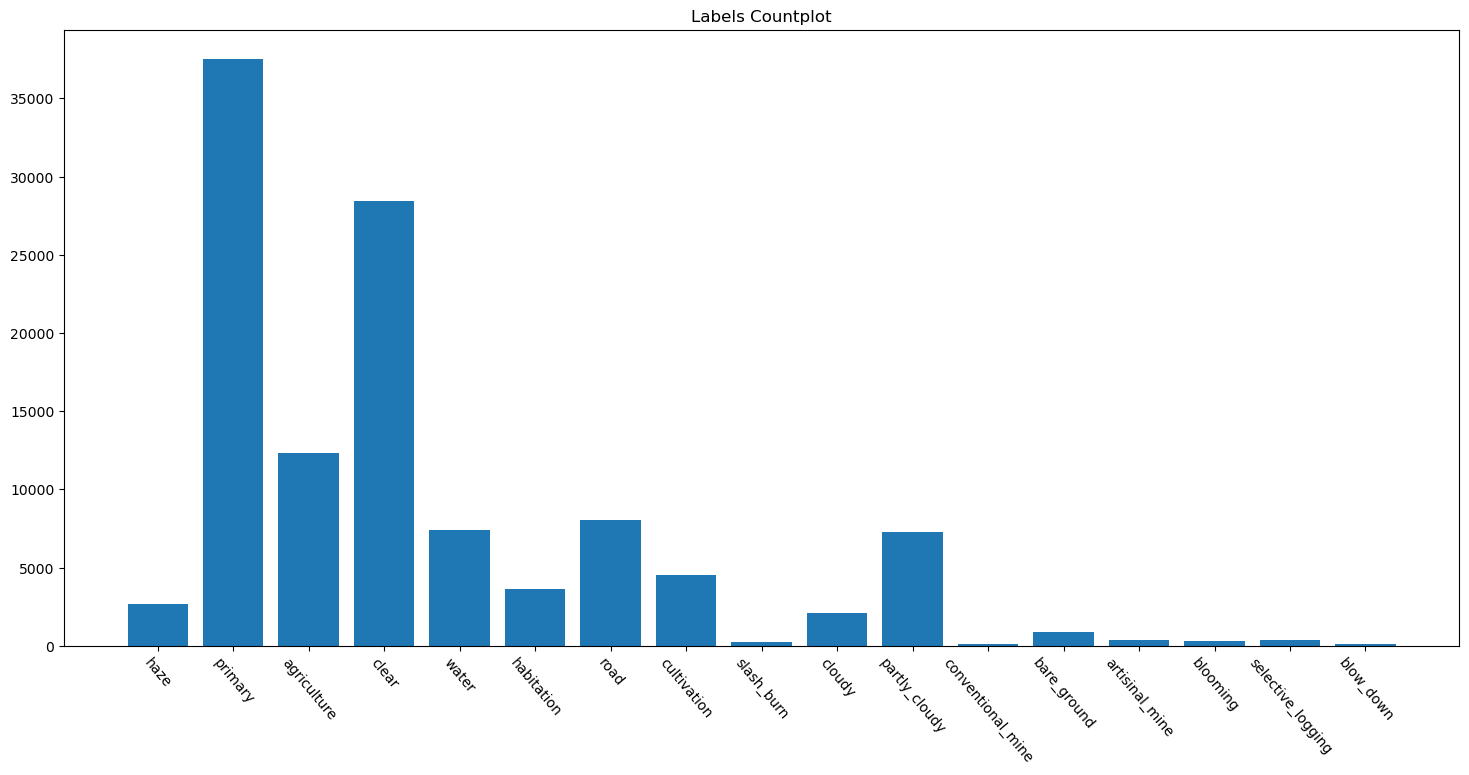

In [27]:
# Histogram of label instances
cnt_label = {}
for label_names in df['tags_split'].values:
  for l in label_names:
    cnt_label[l] = cnt_label[l] + 1 if l in cnt_label else 0

plt.figure(figsize=(18,8))
idxs = range(len(cnt_label.values()))
plt.bar(idxs, cnt_label.values())
plt.xticks(idxs, cnt_label.keys(), rotation=-50)
plt.title('Labels Countplot')
plt.show()

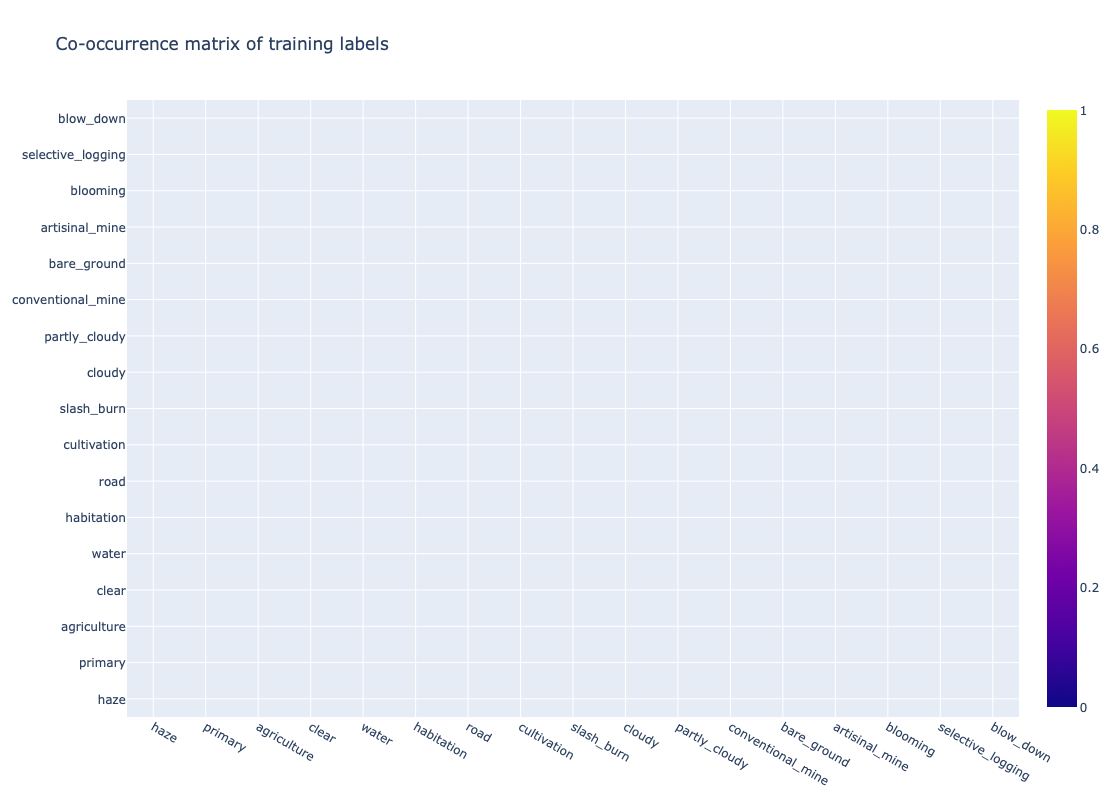

In [40]:
import plotly.graph_objs as go
import plotly.offline as py


counts = cnt_label
com = np.zeros([len(counts)] * 2)

for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in df['tags_split'].values:
            if l in row:
                c += 1
                if l2 in row:
                    cy += 1
        com[i, i2] = cy / c if c > 0 else 0
        
data = [go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout = go.Layout(height=800, width=800, title='Co-occurrence matrix of training labels')
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='train-com')

##### It's worth noting that this co-occurence matrix shows what percentage of the X label also has the Y label - this shows more information than the standard symmetrical matrix.
##### We can see that the label "primary" has the highest proportion of labels.

## Images

#### Now, what you all came for. Let's load some of the images, and their corresponding labels.

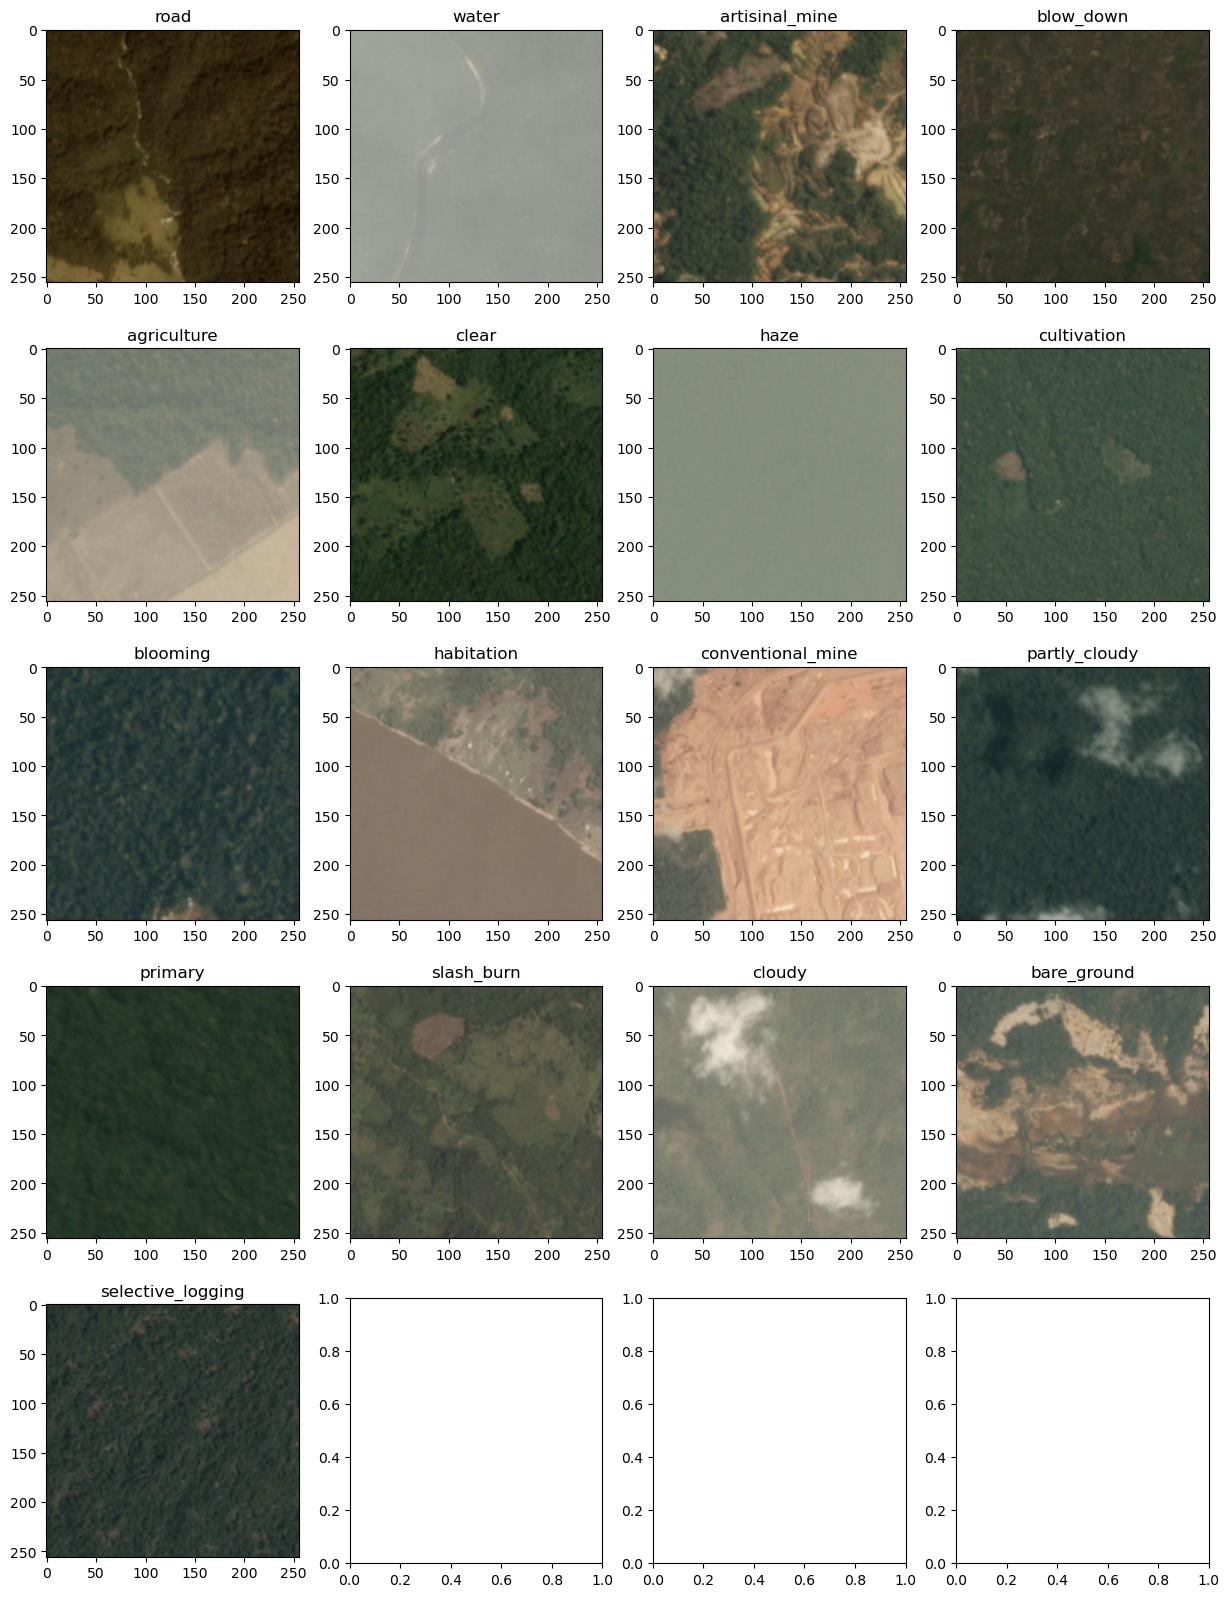

In [65]:
images_title = [df[df['tags'].str.contains(label)].iloc[i]['image_name'] for i, label in enumerate(labels)]

_, ax = plt.subplots(5,4, figsize=(15,20))
ax = ax.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels)):
  img = mpimg.imread(image_name)
  ax[i].imshow(img)
  ax[i].set_title('{}'.format(label))

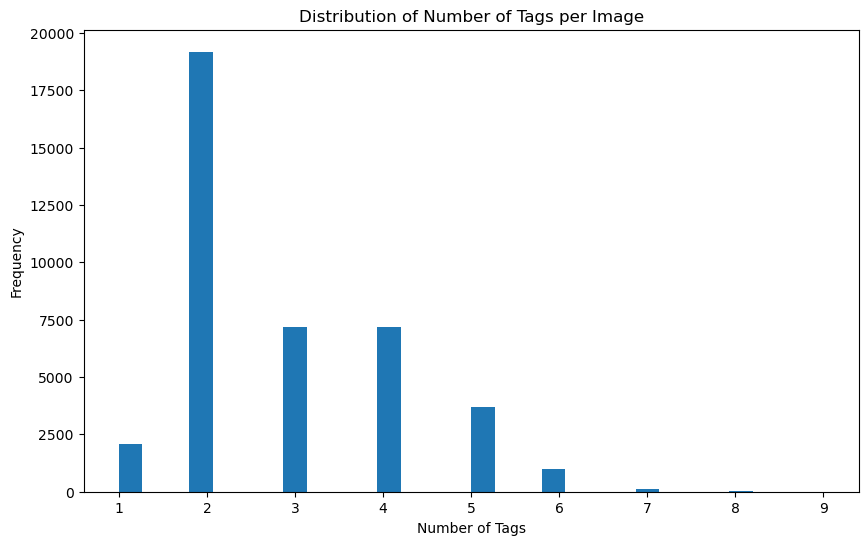

In [67]:
df['tag_count'] = df['tags_split'].apply(len)
plt.figure(figsize=(10, 6))
plt.hist(df['tag_count'], bins=30)
plt.title('Distribution of Number of Tags per Image')
plt.xlabel('Number of Tags')
plt.ylabel('Frequency')
plt.show()